## Purpose

### Title: PCA & Factor Structure
### Description:
Runs PCA on first differences of yields (Δyields) for 5Y government yields across countries.

Examines:
- Full-sample factor structure
- Rolling variance explained by PC1
- PC1 eigenvector (loading) stability over time
- Differences in factor structure across volatility regimes (low vs high MOVE)

Outputs support interpretation of global vs relative rate factors and inform pair eligibility selection in subsequent tasks.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.decomposition import PCA

PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "DATA" / "raw"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

PROJECT_ROOT, DATA_RAW, RESULTS_DIR


(PosixPath('/Users/krex8/Projects/Cross-Country-Rates-Relative-Value-NUSInvest2526'),
 PosixPath('/Users/krex8/Projects/Cross-Country-Rates-Relative-Value-NUSInvest2526/DATA/raw'),
 PosixPath('/Users/krex8/Projects/Cross-Country-Rates-Relative-Value-NUSInvest2526/results'))

In [2]:
TENOR = "5Y"
ROLLING_WINDOW = 252
FREQ = "B"
STANDARDIZE = True

LOW_VOL_Q = 0.33
HIGH_VOL_Q = 0.67


In [3]:
import sys
sys.path.append(str(PROJECT_ROOT))

from src.data.load_raw import _read_bbg_csv

bond_yields_path = DATA_RAW / "bond_yields.csv"
move_path = DATA_RAW / "OCE BofA MOVE INDEX.csv"

bond_df = _read_bbg_csv(bond_yields_path)
move_df = _read_bbg_csv(move_path)

bond_df.shape, move_df.shape

((9388, 15), (9309, 1))

In [4]:
bond_cols = [c for c in bond_df.columns if TENOR in c]
yields = bond_df[bond_cols].copy()

bond_cols

['GTUSD5Y Govt',
 'GTEUR5Y Govt',
 'GTJPY5Y Govt',
 'GTCNY5Y Govt',
 'GTAUD5Y Govt']

In [5]:
yields_b = yields.asfreq(FREQ)
move_b = move_df.asfreq(FREQ)

move_series = move_b.iloc[:, 0].rename("MOVE")

df_level = yields_b.join(move_series, how="inner")
df_level.shape

(9392, 6)

In [6]:
dy = df_level[yields.columns].diff()

move_aligned = df_level["MOVE"]

dy = dy.dropna(how="any")
move_aligned = move_aligned.reindex(dy.index)

dy.shape

(4521, 5)

In [7]:
X = dy.copy()

if STANDARDIZE:
    X = (X - X.mean()) / X.std(ddof=0)

X = X.dropna(how="any")
X.shape

(4521, 5)

In [8]:
pca = PCA(n_components=min(X.shape[1], 10))
pca.fit(X.values)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

explained[:5], cum_explained[:5]

(array([0.34636799, 0.23296929, 0.19560672, 0.13403695, 0.09101905]),
 array([0.34636799, 0.57933728, 0.774944  , 0.90898095, 1.        ]))

In [9]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)

pc1 = loadings["PC1"].sort_values(ascending=False)
pc1.to_frame("PC1_loading")

,PC1_loading
GTEUR5Y Govt,0.597493
GTUSD5Y Govt,0.553438
GTAUD5Y Govt,0.429979
GTJPY5Y Govt,0.377729
GTCNY5Y Govt,0.095644


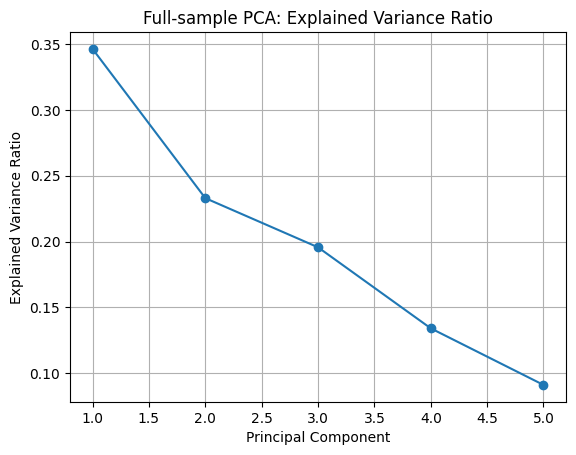

In [10]:
plt.figure()
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.title("Full-sample PCA: Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

In [11]:
baseline_pc1 = loadings["PC1"].values.copy()

def align_to_baseline(vec, baseline):
    if np.dot(vec, baseline) < 0:
        return -vec
    return vec

pc1_var = []
pc1_cos = []
pc1_loadings_over_time = []
idx = []

cols = X.columns.tolist()
Xv = X.values

for end in range(ROLLING_WINDOW, len(X)):
    start = end - ROLLING_WINDOW
    Xw = Xv[start:end, :]
    if np.isnan(Xw).any():
        continue

    p = PCA(n_components=1)
    p.fit(Xw)

    v = float(p.explained_variance_ratio_[0])
    vec = p.components_[0].copy()
    vec = align_to_baseline(vec, baseline_pc1)

    cos = float(
        np.dot(vec, baseline_pc1)
        / (np.linalg.norm(vec) * np.linalg.norm(baseline_pc1))
    )

    pc1_var.append(v)
    pc1_cos.append(cos)
    pc1_loadings_over_time.append(vec)
    idx.append(X.index[end])

roll = pd.DataFrame(
    {"pc1_var": pc1_var, "pc1_cosine_to_fullsample": pc1_cos},
    index=pd.to_datetime(idx)
)

pc1_loadings_over_time = pd.DataFrame(
    pc1_loadings_over_time,
    index=roll.index,
    columns=cols
)

roll.shape

(4269, 2)

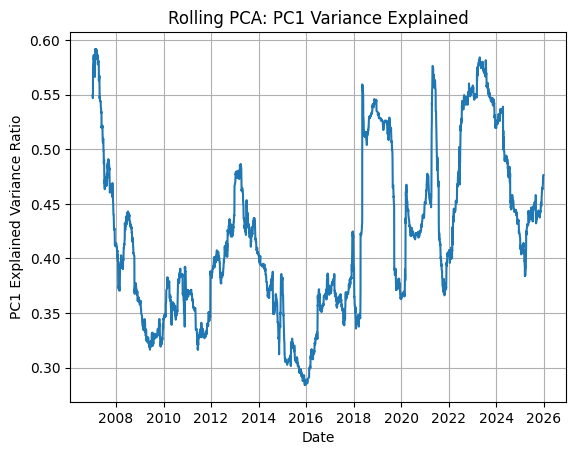

In [12]:
plt.figure()
plt.plot(roll.index, roll["pc1_var"])
plt.title("Rolling PCA: PC1 Variance Explained")
plt.xlabel("Date")
plt.ylabel("PC1 Explained Variance Ratio")
plt.grid(True)
plt.show()

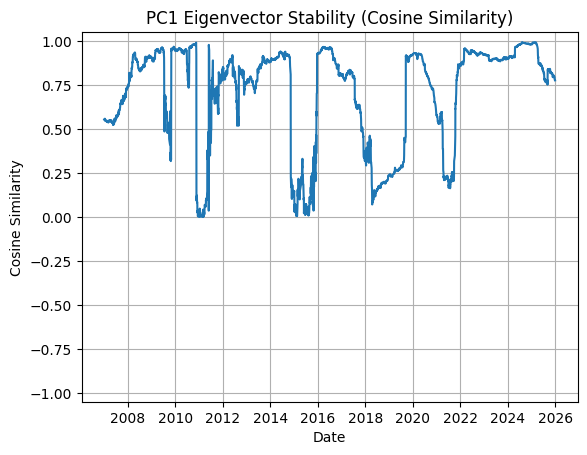

In [13]:
plt.figure()
plt.plot(roll.index, roll["pc1_cosine_to_fullsample"])
plt.title("PC1 Eigenvector Stability (Cosine Similarity)")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.ylim(-1.05, 1.05)
plt.grid(True)
plt.show()

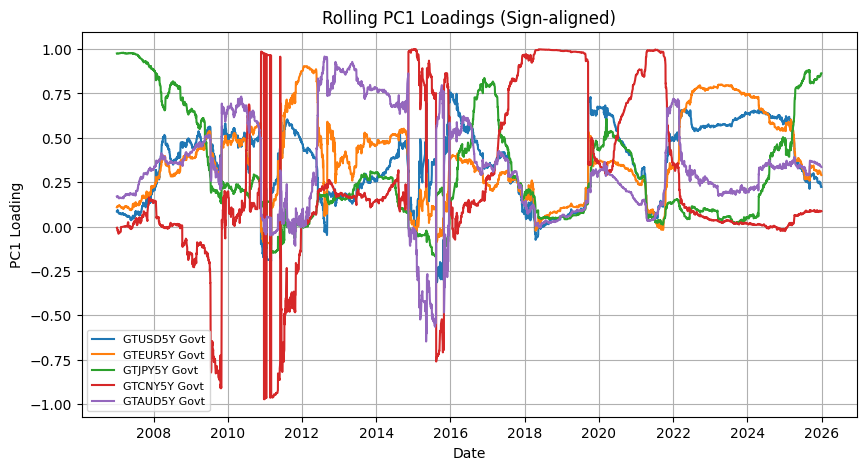

In [14]:
plt.figure(figsize=(10, 5))
for c in pc1_loadings_over_time.columns:
    plt.plot(pc1_loadings_over_time.index, pc1_loadings_over_time[c], label=c)

plt.title("Rolling PC1 Loadings (Sign-aligned)")
plt.xlabel("Date")
plt.ylabel("PC1 Loading")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [15]:
move_roll = move_aligned.reindex(roll.index).dropna()

low_thr = move_roll.quantile(LOW_VOL_Q)
high_thr = move_roll.quantile(HIGH_VOL_Q)

low_idx = move_roll.index[move_roll <= low_thr]
high_idx = move_roll.index[move_roll >= high_thr]

float(low_thr), float(high_thr)

(67.44, 95.66760000000002)

In [16]:
def run_pca_subset(X_df):
    p = PCA(n_components=min(X_df.shape[1], 10))
    p.fit(X_df.values)
    load = pd.Series(p.components_[0], index=X_df.columns)
    evr = float(p.explained_variance_ratio_[0])
    return evr, load.sort_values(ascending=False)

X_roll_aligned = X.loc[roll.index]

X_low = X_roll_aligned.loc[low_idx].dropna(how="any")
X_high = X_roll_aligned.loc[high_idx].dropna(how="any")

evr_low, pc1_low = run_pca_subset(X_low)
evr_high, pc1_high = run_pca_subset(X_high)

evr_low, evr_high

(0.36398460489086665, 0.3925758087326278)

In [17]:
roll.to_csv(RESULTS_DIR / f"pca_{TENOR}_rolling_pc1_metrics.csv")
pc1_loadings_over_time.to_csv(RESULTS_DIR / f"pca_{TENOR}_rolling_pc1_loadings.csv")
loadings.to_csv(RESULTS_DIR / f"pca_{TENOR}_fullsample_loadings.csv")
pc1_low.to_csv(RESULTS_DIR / f"pca_{TENOR}_pc1_loadings_low_vol.csv")
pc1_high.to_csv(RESULTS_DIR / f"pca_{TENOR}_pc1_loadings_high_vol.csv")

RESULTS_DIR

PosixPath('/Users/krex8/Projects/Cross-Country-Rates-Relative-Value-NUSInvest2526/results')

### Full-sample PCA: factor interpretation
The first principal component explains approximately 35% of total variance in standardized 5Y yield changes across countries. PC1 loadings are all positive, with broadly similar magnitudes across USD, EUR, AUD, JPY, and CNY curves.

This pattern is consistent with a global rates factor, capturing common duration/risk-on-off shocks rather than country-specific dynamics. The absence of sign flips or single-country dominance suggests that standardization successfully removed volatility-driven distortions.

Higher-order components (PC2–PC3) together explain a substantial additional share of variance, indicating that meaningful relative and regional structure exists beyond the global factor.

### Rolling PC1 variance: dominance of global factor over time
Rolling PCA shows that PC1 variance explained is time-varying, ranging roughly from ~30% in calm periods to ~55–60% during stress regimes.

Periods of elevated PC1 variance coincide with known macro stress episodes, indicating forced convergence of yield changes across countries. In these regimes, relative value opportunities are structurally impaired, as cross-country spreads are dominated by global shocks rather than idiosyncratic mean-reversion forces.

Conversely, lower PC1 variance regimes correspond to environments where relative components regain explanatory power, **which is a necessary condition for stable RV relationships.**

### Eigenvector (loading) stability: structural regime shifts
The cosine similarity between rolling PC1 eigenvectors and the full-sample PC1 reveals **pronounced but episodic instability.**

While PC1 remains highly stable (cosine similarity near 1) for extended periods, there are sharp drops toward zero during several intervals. These episodes indicate structural redefinition of the dominant factor, rather than simple increases in volatility.

Such eigenvector instability aligns with known failure modes in rates RV strategies, where policy regime changes or funding stress alter the transmission mechanism of global shocks.

### Volatility-conditioned PCA (regime split)
Comparing PCA results across MOVE-defined regimes:
High-volatility regimes:
PC1 explains a significantly larger share of variance.
Loadings become more uniform across countries.
Cross-country differentiation collapses.
Low-volatility regimes:
PC1 dominance weakens.
Higher-order components become more economically meaningful.
Conditions are more favorable for relative value strategies.
This confirms that factor structure itself is regime-dependent, and that RV validity cannot be assessed using full-sample statistics alone.
Implication for relative value construction
A candidate cross-country spread is only economically defensible as relative value if:
Its exposure to PC1 is limited in low-volatility regimes, and
The underlying factor structure remains stable (no persistent eigenvector drift).
Pairs that load materially on PC1, or that exhibit instability during stress regimes, represent disguised directional trades rather than true RV.